In [30]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')

# Project Description 

Given information about videos uploaded on an online platform, develop a classification model to assign videos into 3 groups:
- ”Hot” - Videos are trending up.
- “Stable and Popular” - video view counts are flat, but very high. 
- “Everything else” - videos are not trending up or popular.

Based on the classification model, identify the characteristics of videos that are trending up.

# Data 

- video_id : unique for each video
- count : total count of views for each video
- date : on which day that video was watched that many times
- video_length : length of the video in seconds
- video_language : language of the video
- video_upload_date : when the video was uploaded
- video_quality : quality of the video. It can be [ 240p, 360p, 480p, 720p, 1080p]


In [6]:
video_count=pandas.read_csv("video_count.csv")
video_count

,video_id,count,date
0,2303,22,2015-01-07
1,1193,54854,2015-01-12
2,1219,1788779,2015-01-03
3,1472,234,2015-01-04
4,2947,14407,2015-01-08
...,...,...,...
41770,2168,72747,2015-01-02
41771,2710,2986363,2015-01-08
41772,893,733,2015-01-08
41773,435,178472,2015-01-07


In [7]:
video_features=pandas.read_csv("features.csv")
video_features

,video_id,video_length,video_language,video_upload_date,video_quality
0,2374,1760,Cn,2014-12-06,480p
1,1897,489,Cn,2014-12-10,720p
2,2386,1273,Es,2014-12-05,480p
3,2912,986,Es,2014-12-10,240p
4,2432,1050,Other,2014-12-10,480p
...,...,...,...,...,...
2780,3,807,En,2014-12-15,1080p
2781,588,370,Es,2014-12-09,720p
2782,1209,1491,Other,2014-12-08,480p
2783,1940,155,En,2014-12-18,720p


In [10]:
# all videos in the video_count table are in the feature table. There is no missing data 
len(video_count['video_id'].unique()) == len(video_features['video_id'].unique())

True

In [5]:
#merge two datasets 
data=pandas.merge(left=video_count, right=video_features, how='left')

In [11]:
data.describe(include='all')

,video_id,count,date,video_length,video_language,video_upload_date,video_quality
count,41775.000000,4.177500e+04,41775,41775.000000,41775,41775,41775
unique,NaN,NaN,15,NaN,6,23,5
top,NaN,NaN,2015-01-14,NaN,Cn,2014-12-10,1080p
freq,NaN,NaN,2785,NaN,12570,3630,11940
mean,1498.673250,6.243710e+05,NaN,684.813285,NaN,NaN,NaN
std,864.094856,8.879097e+05,NaN,422.420884,NaN,NaN,NaN
min,1.000000,1.000000e+00,NaN,9.000000,NaN,NaN,NaN
25%,754.000000,9.095500e+03,NaN,363.000000,NaN,NaN,NaN
50%,1492.000000,1.795580e+05,NaN,631.000000,NaN,NaN,NaN
75%,2236.000000,9.043615e+05,NaN,973.000000,NaN,NaN,NaN


In [13]:
# sort the table by date
data_class = data.sort_values(by='date')
  
#check that date difference for each video_id between consecutive rows is always one
consecutive_days = data_class.groupby('video_id')['date'].transform(lambda x: pandas.to_datetime(x).diff()) 
  
#all days are consecutives
print(consecutive_days.dropna().unique().astype('timedelta64[D]'))

[1]


In [14]:
# to classify videos, first calculate the daily percentage change of views 
data_class['pct_change'] = data_class.groupby('video_id')['count'].apply(lambda x: x/x.shift(1)-1)
  
#take the average of pct_change and the average count overall
data_class = data_class.groupby('video_id').apply( lambda x: pandas.Series({
                            'avg_pct_change': x['pct_change'].mean(),
                            'avg_count': x['count'].mean() })
).reset_index() 



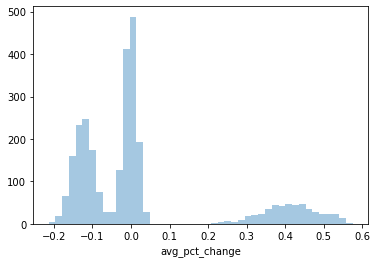

In [17]:
# plot avg_pct_change
sns.distplot(data_class['avg_pct_change'], kde=False)
plt.show()

Based on the plot, we can separate videos into two groups by seting threshold as 0.2. Define as “hot” all videos whose average percentage change is > 0.2.

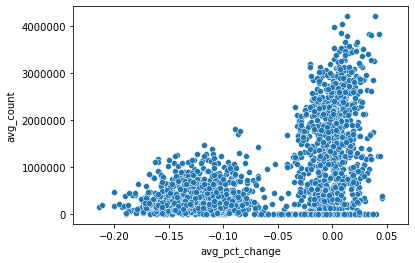

In [18]:

sns.scatterplot(data=data_class.query('avg_pct_change<0.2'), x="avg_pct_change", y="avg_count")
plt.show()

Looking at the plot, we can define videos whose percentage change is between -0.05 and +0.05 as stable.

Since we don't want to recommend videos that are not popular, we can pick a cut-off around 2 millions. All videos trending down are below that value as well as most of the stable videos.

In [20]:
#Label videos 
data_class['class'] = np.where(data_class['avg_pct_change']>0.2, "hot",
                      np.where((data_class['avg_pct_change']>-0.05) & (data_class['avg_count']>2000000), "stable and popular", "everything else"))
  


In [22]:
#check the count
data_class['class'].value_counts()

everything else       1982
hot                    500
stable and popular     303
Name: class, dtype: int64

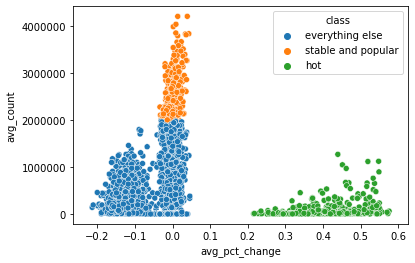

In [24]:
#plot the clusters
sns.scatterplot(data=data_class, x="avg_pct_change", y="avg_count", hue="class")
plt.show()

In [28]:
# Now we have labels, we can build a decision tree to separate hot videos from others 

#label the video
data_tree=pandas.merge(left=video_features, right=data_class[["video_id", "class"]], how='left')
data_tree['class'] = np.where(data_tree['class']=="hot", 1, 0)
  
# extract week of the year and day of the week from date
data_tree['upload_weekday']  = pandas.to_datetime(data_tree['video_upload_date']).dt.strftime('%A')
data_tree['upload_weekyear'] = pandas.to_datetime(data_tree['video_upload_date']).dt.strftime('%U').astype(int)
del data_tree['video_upload_date'] 
del data_tree['video_id']
  
#create dummy variables 
data_dummy = pandas.get_dummies(data_tree, drop_first=True)
train_cols = data_dummy.drop('class', axis=1)
  
#build the tree
dt=DecisionTreeClassifier(
    max_depth=4,
    #change weights given that we have unbalanced classes
    class_weight="balanced",
    min_impurity_decrease = 0.001
    )
dt.fit(train_cols,data_dummy['class'])

DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_impurity_decrease=0.001)

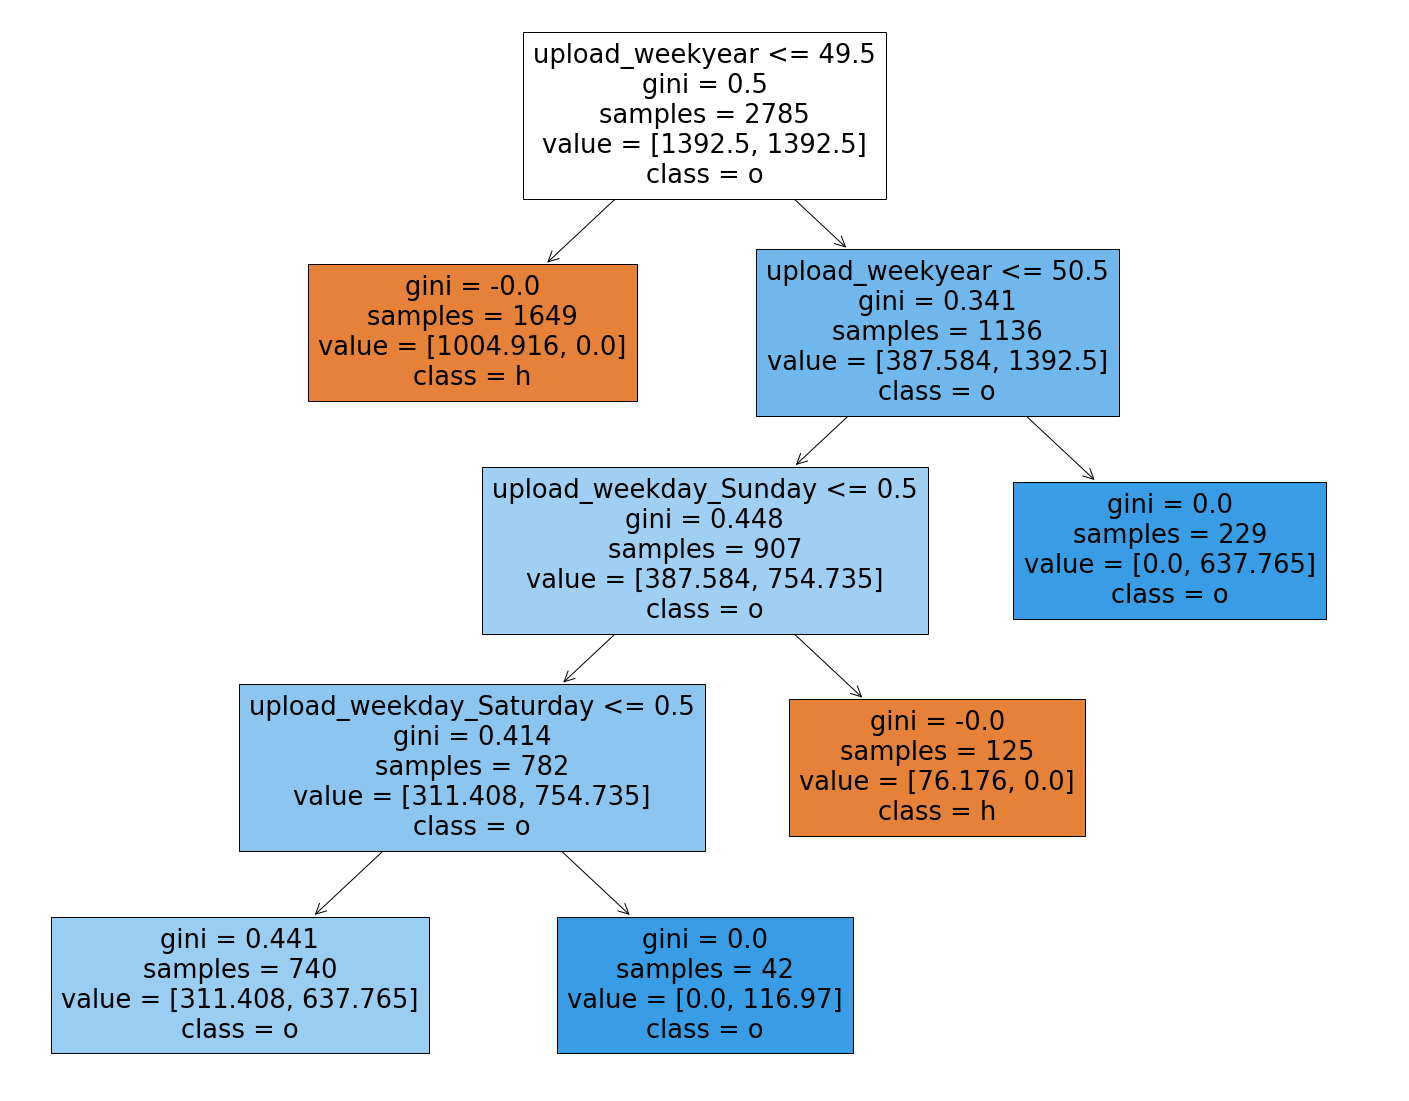

In [31]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt, 
                   feature_names=train_cols.columns,  
                   class_names='hot',
                   filled=True)


From the first split of the decision tree, we can see that hot videos should be the ones that are recently uploaded. However, this is not too actionable. Let’s rebuild the tree w/o the time-related variables.



In [32]:
#remove the time related variables 
data_dummy = pandas.get_dummies(data_tree[['video_length', 'video_language', 'video_quality', 'class']], drop_first=True)
train_cols = data_dummy.drop('class', axis=1)
  
#build the tree
tree_no_time=DecisionTreeClassifier(
    max_depth=4,
    class_weight="balanced",
    min_impurity_decrease = 0.001
    )
tree_no_time.fit(train_cols,data_dummy['class'])

DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_impurity_decrease=0.001)

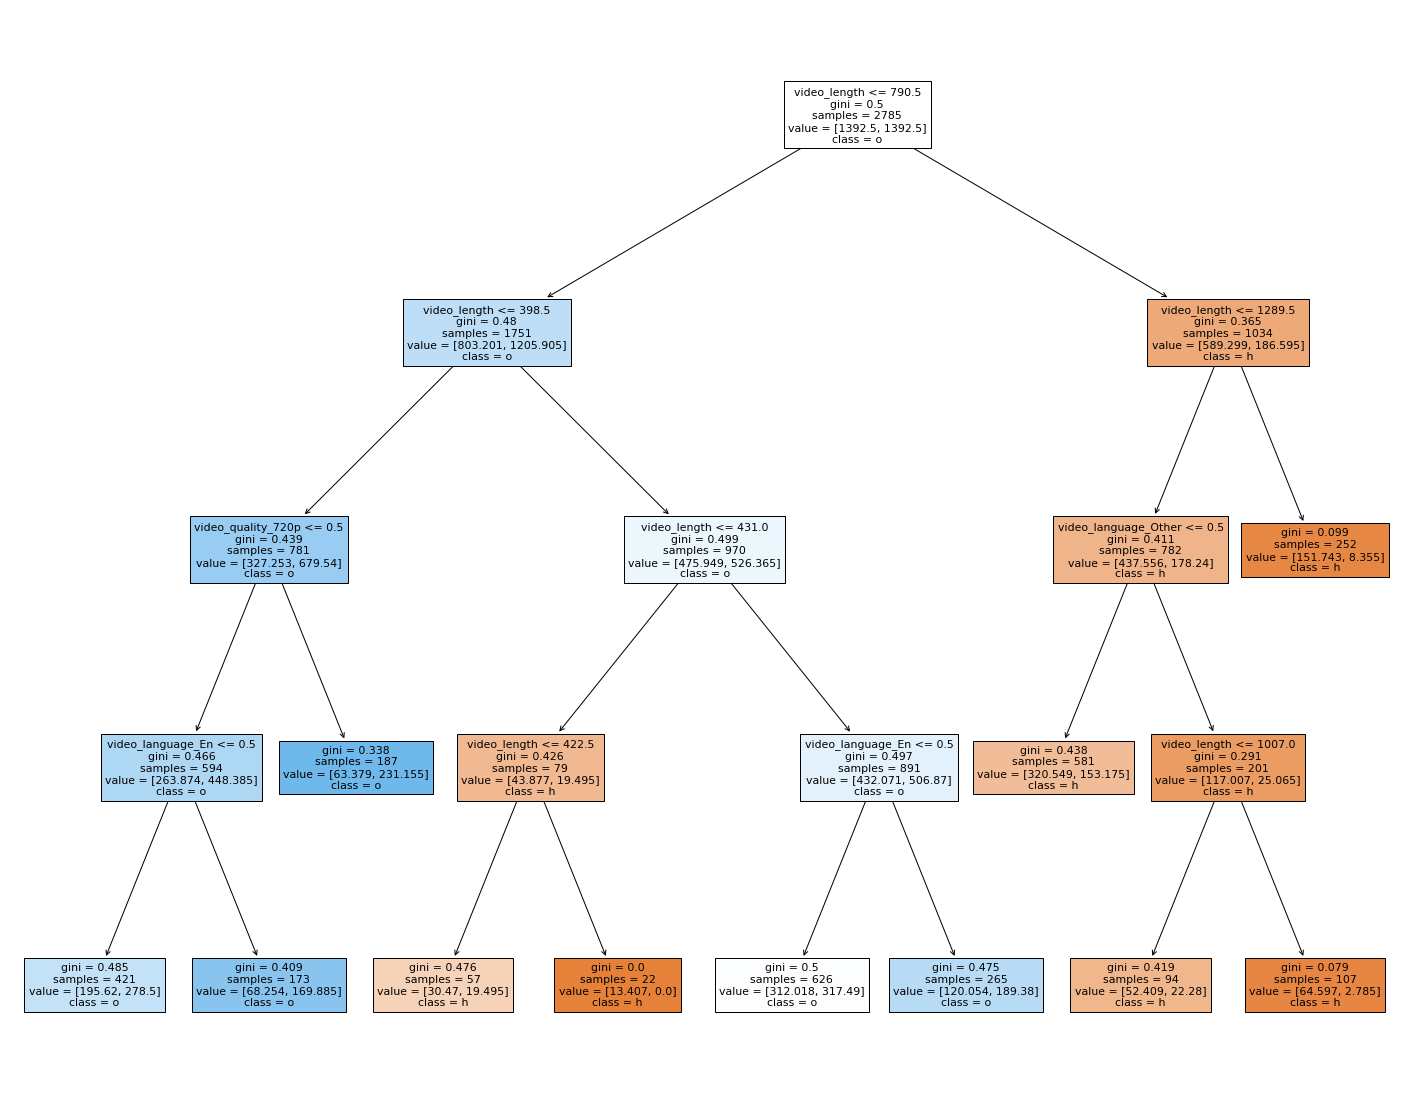

In [33]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree_no_time, 
                   feature_names=train_cols.columns,  
                   class_names='hot',
                   filled=True)


Video_length becomes the first split. Shorter videos are better. There seems to be clear cut-offs around 13 minutes (791 seconds), 7 minutes (399 seconds), 21 minutes (1290 seconds). The shorter the video, always the higher is the probability of being hot

Also, we can see that English always leads to higher probability of a video being hot.






Given that vidoe length is the most important feature, the company should encourage users to upload shorter videos(less than 7 minutes). If a user uploads a video that is too long, have a pop-up notification.